In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['58MA','total'])
    lista_ine2.append(ine_ods[date].loc['156B','total'])
    lista_ine3.append(ine_ods[date].loc['34CZ','total'])
    lista_ine4.append(ine_ods[date].loc['165V','total'])
    lista_ine5.append(ine_ods[date].loc['13VI','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,16278
2020-04-02,16895
2020-04-03,18153
2020-04-04,13180
2020-04-05,11805


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,30777.061728
std,13658.229593
min,10416.000000
25%,18843.000000
50%,30457.000000
75%,42480.000000
max,55828.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,18261.733333
2020-05-31,32278.387097
2020-06-30,47223.000000


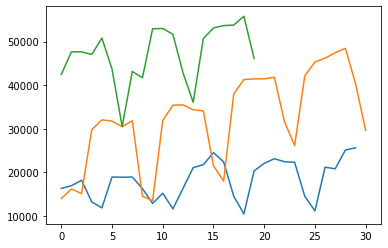

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
dataset = df.values
dataset = dataset.astype('float32')

In [16]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [20]:
print(trainX)

[[0.12908483 0.14267153 0.17037347 0.06086496 0.03058663 0.18677881
  0.18556768]
 [0.14267153 0.17037347 0.06086496 0.03058663 0.18677881 0.18556768
  0.18671277]
 [0.17037347 0.06086496 0.03058663 0.18677881 0.18556768 0.18671277
  0.12793976]
 [0.06086496 0.03058663 0.18677881 0.18556768 0.18671277 0.12793976
  0.05317977]
 [0.03058663 0.18677881 0.18556768 0.18671277 0.12793976 0.05317977
  0.10444376]
 [0.18677881 0.18556768 0.18671277 0.12793976 0.05317977 0.10444376
  0.02567604]
 [0.18556768 0.18671277 0.12793976 0.05317977 0.10444376 0.02567604
  0.1293931 ]
 [0.18671277 0.12793976 0.05317977 0.10444376 0.02567604 0.1293931
  0.23418918]
 [0.12793976 0.05317977 0.10444376 0.02567604 0.1293931  0.23418918
  0.24907511]
 [0.05317977 0.10444376 0.02567604 0.1293931  0.23418918 0.24907511
  0.31002817]
 [0.10444376 0.02567604 0.1293931  0.23418918 0.24907511 0.31002817
  0.26323438]
 [0.02567604 0.1293931  0.23418918 0.24907511 0.31002817 0.26323438
  0.08909538]
 [0.1293931  0.23

In [21]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
print(trainX)

[[[0.12908483]
  [0.14267153]
  [0.17037347]
  [0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]]

 [[0.14267153]
  [0.17037347]
  [0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]]

 [[0.17037347]
  [0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]]

 [[0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]]

 [[0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]]

 [[0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]]

 [[0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]
  [0.1293931 ]]

 [[0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]
  [0.1293931 ]
  [0.23418918]]

 [[0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]
  [0.1293931 ]
  [0.23418918]
  [0.24907511]]

 [[0.05317977]
  [0.10444376]
  [0.02

In [23]:
print(trainY)

[0.18671277 0.12793976 0.05317977 0.10444376 0.02567604 0.1293931
 0.23418918 0.24907511 0.31002817 0.26323438 0.08909538 0.
 0.21734342 0.25565928 0.27919933 0.2640932  0.2611204  0.08898529
 0.01559059 0.23639125 0.2282216  0.32315245 0.33438298 0.07749054
 0.12613407 0.10285828 0.42594466 0.47579935 0.46945742 0.44131508
 0.47130713 0.08935964 0.06632608 0.47229806 0.5499207  0.5517484
 0.52682114 0.5209416  0.24343786 0.16645381 0.6077689  0.67957807
 0.68307936 0.68316746 0.6916013  0.46597818 0.34607592 0.69827354
 0.76862943 0.78765523 0.8153131  0.83762    0.6593411 ]


# Creamos la red neuronal

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [25]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0100 - val_loss: 0.0365
Epoch 124/200
53/53 - 0s - loss: 0.0124 - val_loss: 0.0225
Epoch 125/200
53/53 - 0s - loss: 0.0094 - val_loss: 0.0209
Epoch 126/200
53/53 - 0s - loss: 0.0106 - val_loss: 0.0198
Epoch 127/200
53/53 - 0s - loss: 0.0103 - val_loss: 0.0222
Epoch 128/200
53/53 - 0s - loss: 0.0095 - val_loss: 0.0215
Epoch 129/200
53/53 - 0s - loss: 0.0087 - val_loss: 0.0324
Epoch 130/200
53/53 - 0s - loss: 0.0131 - val_loss: 0.0178
Epoch 131/200
53/53 - 0s - loss: 0.0112 - val_loss: 0.0167
Epoch 132/200
53/53 - 0s - loss: 0.0123 - val_loss: 0.0346
Epoch 133/200
53/53 - 0s - loss: 0.0122 - val_loss: 0.0351
Epoch 134/200
53/53 - 0s - loss: 0.0093 - val_loss: 0.0276
Epoch 135/200
53/53 - 0s - loss: 0.0119 - val_loss: 0.0243
Epoch 136/200
53/53 - 0s - loss: 0.0099 - val_loss: 0.0324
Epoch 137/200
53/53 - 0s - loss: 0.0084 - val_loss: 0.0282
Epoch 138/200
53/53 - 0s - loss: 0.0096 - val_loss: 0.0187
Epoch 139/200
53/53 - 0s - loss: 0.0116 - val_loss: 0.03

# Visualizamos resultados

In [26]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [27]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [28]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 2592.89 MAE
Resultado del entrenamiento: 11686882.62 MSE
Resultado del entrenamiento: 3418.61 RMSE
Resultado del entrenamiento: 12.90 CVRMSE
Resultado del entrenamiento: 13.54 MAPE 

Resultado del test: 5652.94 MAE
Resultado del test: 38701647.64 MSE
Resultado del test: 6221.06 RMSE
Resultado del test: 13.09 CVRMSE
Resultado del test: 12.58 MAPE


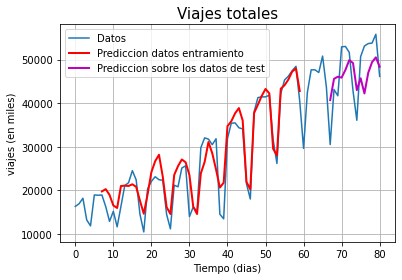

In [29]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [30]:
results=testPredict
print(len(results))

14


In [31]:
testResults = testY_scalerInverse[0]

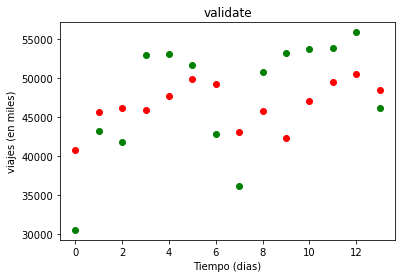

In [32]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

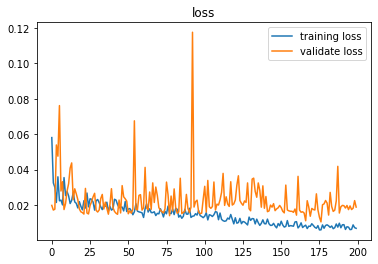

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [34]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

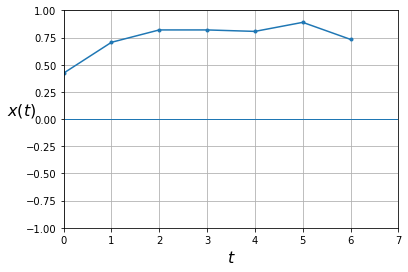

In [35]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [36]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,40713.648438
2020-06-08,45586.007812
2020-06-09,46070.621094
2020-06-10,45864.976562
2020-06-11,47627.156250
2020-06-12,49885.406250
2020-06-13,49205.460938
2020-06-14,42990.910156
2020-06-15,45713.144531
2020-06-16,42233.656250


In [37]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,30490,40713.648438
2020-06-08,43136,45586.007812
2020-06-09,41698,46070.621094
2020-06-10,52941,45864.976562
2020-06-11,53023,47627.156250
2020-06-12,51677,49885.406250
2020-06-13,42811,49205.460938
2020-06-14,36064,42990.910156
2020-06-15,50699,45713.144531
2020-06-16,53129,42233.656250


In [38]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [39]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-25':'2020-5-31']

In [40]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [41]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [42]:
print(trainX1)

[[0.12908483 0.14267153 0.17037347 0.06086496 0.03058663 0.18677881
  0.18556768]
 [0.14267153 0.17037347 0.06086496 0.03058663 0.18677881 0.18556768
  0.18671277]
 [0.17037347 0.06086496 0.03058663 0.18677881 0.18556768 0.18671277
  0.12793976]
 [0.06086496 0.03058663 0.18677881 0.18556768 0.18671277 0.12793976
  0.05317977]
 [0.03058663 0.18677881 0.18556768 0.18671277 0.12793976 0.05317977
  0.10444376]
 [0.18677881 0.18556768 0.18671277 0.12793976 0.05317977 0.10444376
  0.02567604]
 [0.18556768 0.18671277 0.12793976 0.05317977 0.10444376 0.02567604
  0.1293931 ]
 [0.18671277 0.12793976 0.05317977 0.10444376 0.02567604 0.1293931
  0.23418918]
 [0.12793976 0.05317977 0.10444376 0.02567604 0.1293931  0.23418918
  0.24907511]
 [0.05317977 0.10444376 0.02567604 0.1293931  0.23418918 0.24907511
  0.31002817]
 [0.10444376 0.02567604 0.1293931  0.23418918 0.24907511 0.31002817
  0.26323438]
 [0.02567604 0.1293931  0.23418918 0.24907511 0.31002817 0.26323438
  0.08909538]
 [0.1293931  0.23

In [43]:
print(trainY1)

[0.12793976 0.05317977 0.10444376 0.02567604 0.1293931  0.23418918
 0.24907511 0.31002817 0.26323438 0.08909538 0.         0.21734342
 0.25565928 0.27919933 0.2640932  0.2611204  0.08898529 0.01559059
 0.23639125 0.2282216  0.32315245 0.33438298 0.07749054 0.12613407
 0.10285828 0.42594466 0.47579935 0.46945742 0.44131508 0.47130713
 0.08935964 0.06632608 0.47229806 0.5499207  0.5517484  0.52682114
 0.5209416  0.24343786 0.16645381 0.6077689  0.67957807 0.68307936
 0.68316746 0.6916013  0.46597818 0.34607592 0.69827354 0.76862943
 0.78765523 0.8153131  0.83762    0.6593411 ]


In [44]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [45]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0110 - val_loss: 0.0116
Epoch 123/200
52/52 - 0s - loss: 0.0098 - val_loss: 0.0198
Epoch 124/200
52/52 - 0s - loss: 0.0112 - val_loss: 0.0194
Epoch 125/200
52/52 - 0s - loss: 0.0096 - val_loss: 0.0238
Epoch 126/200
52/52 - 0s - loss: 0.0095 - val_loss: 0.0171
Epoch 127/200
52/52 - 0s - loss: 0.0092 - val_loss: 0.0169
Epoch 128/200
52/52 - 0s - loss: 0.0095 - val_loss: 0.0131
Epoch 129/200
52/52 - 0s - loss: 0.0104 - val_loss: 0.0184
Epoch 130/200
52/52 - 0s - loss: 0.0108 - val_loss: 0.0115
Epoch 131/200
52/52 - 0s - loss: 0.0108 - val_loss: 0.0129
Epoch 132/200
52/52 - 0s - loss: 0.0089 - val_loss: 0.0210
Epoch 133/200
52/52 - 0s - loss: 0.0106 - val_loss: 0.0126
Epoch 134/200
52/52 - 0s - loss: 0.0098 - val_loss: 0.0147
Epoch 135/200
52/52 - 0s - loss: 0.0099 - val_loss: 0.0128
Epoch 136/200
52/52 - 0s - loss: 0.0097 - val_loss: 0.0190
Epoch 137/200
52/52 - 0s - loss: 0.0097 - val_loss: 0.0136
Epoch 138/200
52/52 - 0s - loss: 0.0097 - val_loss: 0.0140
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0166 - val_loss: 0.0104
Epoch 44/200
51/51 - 0s - loss: 0.0142 - val_loss: 0.0272
Epoch 45/200
51/51 - 0s - loss: 0.0145 - val_loss: 0.0102
Epoch 46/200
51/51 - 0s - loss: 0.0135 - val_loss: 0.0174
Epoch 47/200
51/51 - 0s - loss: 0.0121 - val_loss: 0.0101
Epoch 48/200
51/51 - 0s - loss: 0.0139 - val_loss: 0.0129
Epoch 49/200
51/51 - 0s - loss: 0.0136 - val_loss: 0.0097
Epoch 50/200
51/51 - 0s - loss: 0.0136 - val_loss: 0.0099
Epoch 51/200
51/51 - 0s - loss: 0.0136 - val_loss: 0.0113
Epoch 52/200
51/51 - 0s - loss: 0.0154 - val_loss: 0.0112
Epoch 53/200
51/51 - 0s - loss: 0.0146 - val_loss: 0.0117
Epoch 54/200
51/51 - 0s - loss: 0.0118 - val_loss: 0.0106
Epoch 55/200
51/51 - 0s - loss: 0.0119 - val_loss: 0.0304
Epoch 56/200
51/51 - 0s - loss: 0.0126 - val_loss: 0.0110
Epoch 57/200
51/51 - 0s - loss: 0.0113 - val_loss: 0.0122
Epoch 58/200
51/51 - 0s - loss: 0.0138 - val_loss: 0.0127
Epoch 59/200
51/51 - 0s - loss: 0.0139 - val_loss: 0.0148
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0094 - val_loss: 0.0144
Epoch 184/200
51/51 - 0s - loss: 0.0109 - val_loss: 0.0150
Epoch 185/200
51/51 - 0s - loss: 0.0100 - val_loss: 0.0166
Epoch 186/200
51/51 - 0s - loss: 0.0086 - val_loss: 0.0147
Epoch 187/200
51/51 - 0s - loss: 0.0089 - val_loss: 0.0153
Epoch 188/200
51/51 - 0s - loss: 0.0086 - val_loss: 0.0162
Epoch 189/200
51/51 - 0s - loss: 0.0091 - val_loss: 0.0184
Epoch 190/200
51/51 - 0s - loss: 0.0095 - val_loss: 0.0164
Epoch 191/200
51/51 - 0s - loss: 0.0083 - val_loss: 0.0167
Epoch 192/200
51/51 - 0s - loss: 0.0083 - val_loss: 0.0169
Epoch 193/200
51/51 - 0s - loss: 0.0088 - val_loss: 0.0150
Epoch 194/200
51/51 - 0s - loss: 0.0097 - val_loss: 0.0171
Epoch 195/200
51/51 - 0s - loss: 0.0096 - val_loss: 0.0211
Epoch 196/200
51/51 - 0s - loss: 0.0108 - val_loss: 0.0159
Epoch 197/200
51/51 - 0s - loss: 0.0093 - val_loss: 0.0157
Epoch 198/200
51/51 - 0s - loss: 0.0113 - val_loss: 0.0170
Epoch 199/200
51/51 - 0s - loss: 0.0093 - val_loss: 0.01

50/50 - 0s - loss: 0.0100 - val_loss: 0.0158
Epoch 105/200
50/50 - 0s - loss: 0.0107 - val_loss: 0.0137
Epoch 106/200
50/50 - 0s - loss: 0.0096 - val_loss: 0.0151
Epoch 107/200
50/50 - 0s - loss: 0.0126 - val_loss: 0.0138
Epoch 108/200
50/50 - 0s - loss: 0.0117 - val_loss: 0.0128
Epoch 109/200
50/50 - 0s - loss: 0.0120 - val_loss: 0.0178
Epoch 110/200
50/50 - 0s - loss: 0.0085 - val_loss: 0.0186
Epoch 111/200
50/50 - 0s - loss: 0.0099 - val_loss: 0.0196
Epoch 112/200
50/50 - 0s - loss: 0.0090 - val_loss: 0.0161
Epoch 113/200
50/50 - 0s - loss: 0.0101 - val_loss: 0.0261
Epoch 114/200
50/50 - 0s - loss: 0.0086 - val_loss: 0.0219
Epoch 115/200
50/50 - 0s - loss: 0.0100 - val_loss: 0.0170
Epoch 116/200
50/50 - 0s - loss: 0.0101 - val_loss: 0.0215
Epoch 117/200
50/50 - 0s - loss: 0.0094 - val_loss: 0.0199
Epoch 118/200
50/50 - 0s - loss: 0.0093 - val_loss: 0.0309
Epoch 119/200
50/50 - 0s - loss: 0.0096 - val_loss: 0.0230
Epoch 120/200
50/50 - 0s - loss: 0.0098 - val_loss: 0.0212
Epoch 121/2

49/49 - 0s - loss: 0.0172 - val_loss: 0.0286
Epoch 25/200
49/49 - 0s - loss: 0.0166 - val_loss: 0.0410
Epoch 26/200
49/49 - 0s - loss: 0.0175 - val_loss: 0.0083
Epoch 27/200
49/49 - 0s - loss: 0.0142 - val_loss: 0.0119
Epoch 28/200
49/49 - 0s - loss: 0.0185 - val_loss: 0.0088
Epoch 29/200
49/49 - 0s - loss: 0.0135 - val_loss: 0.0089
Epoch 30/200
49/49 - 0s - loss: 0.0179 - val_loss: 0.0209
Epoch 31/200
49/49 - 0s - loss: 0.0134 - val_loss: 0.0727
Epoch 32/200
49/49 - 0s - loss: 0.0158 - val_loss: 0.0922
Epoch 33/200
49/49 - 0s - loss: 0.0164 - val_loss: 0.0094
Epoch 34/200
49/49 - 0s - loss: 0.0172 - val_loss: 0.0229
Epoch 35/200
49/49 - 0s - loss: 0.0198 - val_loss: 0.0265
Epoch 36/200
49/49 - 0s - loss: 0.0172 - val_loss: 0.0225
Epoch 37/200
49/49 - 0s - loss: 0.0154 - val_loss: 0.0105
Epoch 38/200
49/49 - 0s - loss: 0.0165 - val_loss: 0.0093
Epoch 39/200
49/49 - 0s - loss: 0.0141 - val_loss: 0.0126
Epoch 40/200
49/49 - 0s - loss: 0.0128 - val_loss: 0.0939
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0086 - val_loss: 0.0143
Epoch 166/200
49/49 - 0s - loss: 0.0098 - val_loss: 0.0075
Epoch 167/200
49/49 - 0s - loss: 0.0075 - val_loss: 0.0072
Epoch 168/200
49/49 - 0s - loss: 0.0089 - val_loss: 0.0102
Epoch 169/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0099
Epoch 170/200
49/49 - 0s - loss: 0.0105 - val_loss: 0.0119
Epoch 171/200
49/49 - 0s - loss: 0.0090 - val_loss: 0.0101
Epoch 172/200
49/49 - 0s - loss: 0.0086 - val_loss: 0.0111
Epoch 173/200
49/49 - 0s - loss: 0.0090 - val_loss: 0.0100
Epoch 174/200
49/49 - 0s - loss: 0.0080 - val_loss: 0.0126
Epoch 175/200
49/49 - 0s - loss: 0.0110 - val_loss: 0.0090
Epoch 176/200
49/49 - 0s - loss: 0.0095 - val_loss: 0.0119
Epoch 177/200
49/49 - 0s - loss: 0.0104 - val_loss: 0.0141
Epoch 178/200
49/49 - 0s - loss: 0.0102 - val_loss: 0.0078
Epoch 179/200
49/49 - 0s - loss: 0.0085 - val_loss: 0.0178
Epoch 180/200
49/49 - 0s - loss: 0.0104 - val_loss: 0.0119
Epoch 181/200
49/49 - 0s - loss: 0.0097 - val_loss: 0.01

Epoch 86/200
48/48 - 0s - loss: 0.0095 - val_loss: 0.0121
Epoch 87/200
48/48 - 0s - loss: 0.0112 - val_loss: 0.0164
Epoch 88/200
48/48 - 0s - loss: 0.0098 - val_loss: 0.0495
Epoch 89/200
48/48 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 90/200
48/48 - 0s - loss: 0.0105 - val_loss: 0.0215
Epoch 91/200
48/48 - 0s - loss: 0.0107 - val_loss: 0.0212
Epoch 92/200
48/48 - 0s - loss: 0.0085 - val_loss: 0.0100
Epoch 93/200
48/48 - 0s - loss: 0.0090 - val_loss: 0.0598
Epoch 94/200
48/48 - 0s - loss: 0.0119 - val_loss: 0.0271
Epoch 95/200
48/48 - 0s - loss: 0.0085 - val_loss: 0.0531
Epoch 96/200
48/48 - 0s - loss: 0.0100 - val_loss: 0.0147
Epoch 97/200
48/48 - 0s - loss: 0.0095 - val_loss: 0.0210
Epoch 98/200
48/48 - 0s - loss: 0.0100 - val_loss: 0.0356
Epoch 99/200
48/48 - 0s - loss: 0.0095 - val_loss: 0.0212
Epoch 100/200
48/48 - 0s - loss: 0.0129 - val_loss: 0.0120
Epoch 101/200
48/48 - 0s - loss: 0.0111 - val_loss: 0.0138
Epoch 102/200
48/48 - 0s - loss: 0.0089 - val_loss: 0.0483
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0416 - val_loss: 0.0401
Epoch 7/200
47/47 - 0s - loss: 0.0414 - val_loss: 0.0245
Epoch 8/200
47/47 - 0s - loss: 0.0362 - val_loss: 0.0541
Epoch 9/200
47/47 - 0s - loss: 0.0353 - val_loss: 0.0278
Epoch 10/200
47/47 - 0s - loss: 0.0390 - val_loss: 0.0346
Epoch 11/200
47/47 - 0s - loss: 0.0371 - val_loss: 0.0422
Epoch 12/200
47/47 - 0s - loss: 0.0371 - val_loss: 0.0425
Epoch 13/200
47/47 - 0s - loss: 0.0480 - val_loss: 0.1037
Epoch 14/200
47/47 - 0s - loss: 0.0365 - val_loss: 0.0274
Epoch 15/200
47/47 - 0s - loss: 0.0348 - val_loss: 0.0442
Epoch 16/200
47/47 - 0s - loss: 0.0361 - val_loss: 0.0236
Epoch 17/200
47/47 - 0s - loss: 0.0366 - val_loss: 0.0235
Epoch 18/200
47/47 - 0s - loss: 0.0388 - val_loss: 0.1470
Epoch 19/200
47/47 - 0s - loss: 0.0420 - val_loss: 0.1444
Epoch 20/200
47/47 - 0s - loss: 0.0309 - val_loss: 0.0301
Epoch 21/200
47/47 - 0s - loss: 0.0379 - val_loss: 0.0506
Epoch 22/200
47/47 - 0s - loss: 0.0393 - val_loss: 0.1304
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0075 - val_loss: 0.0182
Epoch 148/200
47/47 - 0s - loss: 0.0086 - val_loss: 0.0176
Epoch 149/200
47/47 - 0s - loss: 0.0100 - val_loss: 0.0103
Epoch 150/200
47/47 - 0s - loss: 0.0076 - val_loss: 0.0099
Epoch 151/200
47/47 - 0s - loss: 0.0079 - val_loss: 0.0104
Epoch 152/200
47/47 - 0s - loss: 0.0072 - val_loss: 0.0203
Epoch 153/200
47/47 - 0s - loss: 0.0084 - val_loss: 0.0160
Epoch 154/200
47/47 - 0s - loss: 0.0073 - val_loss: 0.0117
Epoch 155/200
47/47 - 0s - loss: 0.0093 - val_loss: 0.0159
Epoch 156/200
47/47 - 0s - loss: 0.0076 - val_loss: 0.0146
Epoch 157/200
47/47 - 0s - loss: 0.0083 - val_loss: 0.0106
Epoch 158/200
47/47 - 0s - loss: 0.0086 - val_loss: 0.0169
Epoch 159/200
47/47 - 0s - loss: 0.0059 - val_loss: 0.0160
Epoch 160/200
47/47 - 0s - loss: 0.0080 - val_loss: 0.0213
Epoch 161/200
47/47 - 0s - loss: 0.0063 - val_loss: 0.0172
Epoch 162/200
47/47 - 0s - loss: 0.0070 - val_loss: 0.0120
Epoch 163/200
47/47 - 0s - loss: 0.0078 - val_loss: 0.01

# Preparamos los datos para el test

In [46]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [47]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [48]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.70635414]
 [0.7491615 ]
 [0.8162613 ]
 [0.81878096]
 [0.96724844]
 [0.754535  ]
 [0.3371516 ]]


# Re-Convertimos los resultados

In [49]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[42917],
       [43724],
       [44990],
       [45037],
       [47836],
       [43826],
       [35956]])

# Visualizamos el pronostico

<AxesSubplot:>

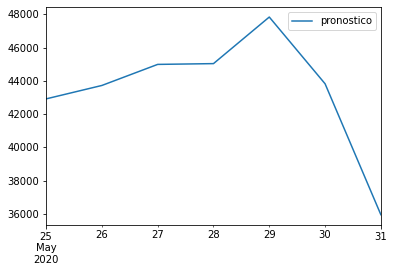

In [50]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [51]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,42126,42917
2020-05-26,45321,43724
2020-05-27,46185,44990
2020-05-28,47441,45037
2020-05-29,48454,47836
2020-05-30,40358,43826
2020-05-31,29599,35956


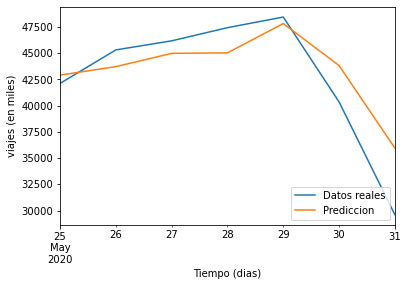

In [52]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [53]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 2347.14 MAE
Resultado del test: 9029104.00 MSE
Resultado del test: 3004.85 RMSE
Resultado del test: 6.91 CVRMSE
Resultado del test: 5.77 MAPE


In [54]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 791.00 MAE
Resultado del test dia 1: 625681.00 MSE
Resultado del test dia 1: 791.00 RMSE
Resultado del test dia 1: 1.84 CVRMSE
Resultado del test dia 1: 1.84 MAPE 

Resultado del test dia 2: 1597.00 MAE
Resultado del test dia 2: 2550409.00 MSE
Resultado del test dia 2: 1597.00 RMSE
Resultado del test dia 2: 3.65 CVRMSE
Resultado del test dia 2: 3.65 MAPE 

Resultado del test dia 3: 1195.00 MAE
Resultado del test dia 3: 1428025.00 MSE
Resultado del test dia 3: 1195.00 RMSE
Resultado del test dia 3: 2.66 CVRMSE
Resultado del test dia 3: 2.66 MAPE 

Resultado del test dia 4: 2404.00 MAE
Resultado del test dia 4: 5779216.00 MSE
Resultado del test dia 4: 2404.00 RMSE
Resultado del test dia 4: 5.34 CVRMSE
Resultado del test dia 4: 5.34 MAPE 

Resultado del test dia 5: 618.00 MAE
Resultado del test dia 5: 381924.00 MSE
Resultado del test dia 5: 618.00 RMSE
Resultado del test dia 5: 1.29 CVRMSE
Resultado del test dia 5: 1.29 MAPE 

Resultado del test dia 6: 3468.00 MA